In [ ]:

import sqlite3
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output, State
from dash import dash_table
from flask import Flask
import plotly.colors as pc
import numpy as np
import sqlite3
import pandas as pd
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks


class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        data = conn.execute(query, (element, sp_num)).fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name, iteration):
        conn = sqlite3.connect(self.db_spectrum)
        query = """
            SELECT wavelength, intensity
            FROM spectrum_data
            WHERE sample_name = ? AND iteration = ?
            ORDER BY wavelength
        """
        data = conn.execute(query, (sample_name, iteration)).fetchall()
        conn.close()
        if not data:
            return np.array([]), np.array([])
        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)
    def get_peak_data(sample_name):
        excel_file = f"da/{sample_name}.xlsx"

        try:
          df = pd.read_excel(excel_file)
          return df
        except FileNotFoundError:
          print(f"Excel file not found: {excel_file}")
          return pd.DataFrame()
        except Exception as e:
          print(f"Error reading Excel file: {e}")
          return pd.DataFrame()

class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = int(resolution)

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)
        energy_levels = []
        degeneracies = []
        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ek = Ek / 8065.544
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    energy_levels.extend([Ei, Ek])
                    degeneracies.extend([gi, gk])
                except ValueError:
                    continue
        Z = self.partition_function(energy_levels, degeneracies, self.temperature)
        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue
        if intensities.size > 0:
            intensities = intensities / np.max(intensities)
        return wavelengths, intensities


def baseline_als(intensities, lam, p, niter):
    lam = lam *1e4
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

server = Flask(__name__)
data_fetcher = DataFetcher(db_nist="data1.db", db_spectrum="tanah_vulkanik.db")

app1 = dash.Dash(__name__, server=server, routes_pathname_prefix='/app1/', external_stylesheets=[dbc.themes.CYBORG])
app2 = dash.Dash(__name__, server=server, routes_pathname_prefix='/app2/')
app3 = dash.Dash(__name__, server=server, routes_pathname_prefix='/app3/', external_stylesheets=[dbc.themes.CYBORG])

app1.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Spectrum Analyzer", className="text-center mb-4"),
            html.P("Aplikasi untuk menganalisis spektrum atom.", className="text-center"),
            html.A('App 2', href='/app2', className="btn btn-secondary mr-2"),
            html.A('App 3', href='/app3', className="btn btn-secondary mr-2"),
            dbc.Card([
                dbc.CardHeader("Input Parameters"),
                dbc.CardBody([
                    dbc.Row([
                        dbc.Col([
                            dbc.Label("Enter Element:", className="form-label"),
                            dbc.Input(id='element-input', type='text', value='Ca', className="form-control")
                        ], className="mb-3"),
                        dbc.Col([
                            dbc.Label("Select Ion Stage:", className="form-label"),
                            dcc.Dropdown(
                                id='ion-stage-dropdown',
                                options=[{'label': str(i), 'value': i} for i in range(1, 6)],
                                value=1,
                                clearable=False,
                                className="form-control"
                            )
                        ], className="mb-3"),
                    ]),
                    dbc.Row([
                        dbc.Col([
                            dbc.Label("Enter Temperature (K):", className="form-label"),
                            dbc.Input(id='temperature-input', type='number', value=9600, min=1000, step=100, className="form-control")
                        ], className="mb-3"),
                        dbc.Col([
                            dbc.Label("Max Intensity:", className="form-label"),
                            dbc.Input(id='max-intensity-input', type='number', value=1, step=0.000001, className="form-control")
                        ], className="mb-3"),
                    ]),
                    dbc.Row([
                        dbc.Col([
                            dbc.Label("Select Sample:", className="form-label"),
                            dcc.Dropdown(
                                id='sample-dropdown',
                                options=[{'label': f"S{i}", 'value': f"S{i}"} for i in range(1, 25)],
                                value="S1",
                                clearable=False,
                                className="form-control"
                            )
                        ], className="mb-3"),
                        dbc.Col([
                            dbc.Label("Iteration:", className="form-label"),
                            dcc.Dropdown(
                                id='iteration-dropdown',
                                options=[{'label': f"{i}", 'value': f"{i}"} for i in range(1, 4)],
                                value="1",
                                clearable=False,
                                className="form-control"
                            )
                        ], className="mb-3"),
                    ]),
                    dbc.Row([
                        dbc.Col(
                            dbc.Button('Analyze', id='analyze-button', n_clicks=0, color="primary", className="mr-2"),
                        ),
                        dbc.Col(
                            dbc.Button('Calibrate', id='calibrate-button', n_clicks=0, color="primary"),
                        ),
                    ]),
                ]),
                dbc.Card([
                    dbc.CardHeader("Baseline Correction Parameters"),
                    dbc.CardBody([
                        dbc.Row([
                            dbc.Col([
                                dbc.Label("Lambda (1e4):", className="form-label"),
                                dbc.Input(id='lam-input', type='number', value=1, min=1, step=1, className="form-control")
                            ]),
                            dbc.Col([
                                dbc.Label("P (p):", className="form-label"),
                                dbc.Input(id='p-input', type='number', value=0.01, min=0, max=1, step=0.001, className="form-control")
                            ]),
                        ]),
                        dbc.Row(
                            dbc.Col([
                                dbc.Label("Number of Iterations (niter):", className="form-label"),
                                dbc.Input(id='niter-input', type='number', value=7, min=1, step=1, className="form-control")
                            ])
                        )
                    ])
                ]),
            ]),
            dbc.Card([
                dbc.CardHeader("Peak Finding Parameters"),
                dbc.CardBody([
                    dbc.Row([
                        dbc.Col([
                            dbc.Label("height :", className="form-label"),
                            dbc.Input(id='height-input', type='number', value=0, step=0.001, className="form-control")
                        ]),
                        dbc.Col([
                            dbc.Label("threshold :", className="form-label"),
                            dbc.Input(id='threshold-input', type='number', value=0.1, step=0.00001, className="form-control")
                        ]),
                    ]),
                    dbc.Row(
                        dbc.Col([
                            dbc.Label("prominence :", className="form-label"),
                            dbc.Input(id='prominence-input', type='number', value=0.00004, step=0.00001, className="form-control")
                        ])
                    )
                ])
            ]),
        ], width=4),
        dbc.Col([
            dbc.Card([
                dbc.CardHeader("Spectrum Plot"),
                dbc.CardBody(
                    dcc.Graph(id='spectrum-plot', style={'height': '600px'})
                )
            ]),
            dbc.Card([
                dbc.CardHeader("Peak Matching Table"),
                dbc.CardBody([
                    dbc.Button('Save to Excel', id='save-table-button', color="primary", className="mb-3"),
                    html.Div(
                        id='peak-table',
                        style={
                            'overflowY': 'auto',
                            'maxHeight': '900px',
                            'overflowX': 'hidden'
                        }
                    )
                ])
            ], className="mt-3"),
        ], width=8)
    ]),
    dbc.Container([
        dcc.ConfirmDialog(
            id='save-notification',
            message='Tabel peak matching berhasil disimpan!'
        ),
    ]),
    dcc.Store(id='peak-table-data'),
    dcc.Store(id='sample-name-store'),  # Menyimpan nama sampel di state
    dbc.Row([  # Tombol untuk menyimpan data spektrum
        dbc.Col([
            dbc.Button('Save Spectrum Data', id='save-spectrum-button', n_clicks=0, color="primary", className="mr-2"),
        ]),
    ]),
], fluid=True)
app2.layout = dbc.Container([
    html.H1("Spectrum Analyzer", className="text-center mb-4"),
    html.A('App 1', href='/app1', className="btn btn-secondary mr-2"),
    html.A('App 3', href='/app3', className="btn btn-secondary mr-2"),
    dbc.Card([
        dbc.CardBody([
            dbc.Row([
                dbc.Col([
                    dbc.Label("Select Sample:", className="form-label"),
                    dcc.Dropdown(
                        id='sample-dropdown',
                        options=[{'label': f"S{i}", 'value': f"S{i}"} for i in range(1, 25)],
                        value="S1",
                        clearable=False,
                        className="form-control"
                    )
                ], className="mb-3"),
                dbc.Col([
                    dbc.Label("Iteration:", className="form-label"),
                    dcc.Dropdown(
                        id='iteration-dropdown',
                        options=[{'label': f"{i}", 'value': f"{i}"} for i in range(1, 4)],
                        value="1",
                        clearable=False,
                        className="form-control"
                    )
                ], className="mb-3"),
            ]),
            dbc.Row([
                dbc.Col(
                    dcc.Input(
                        id='intensity-threshold',
                        type='number',
                        placeholder='Enter Intensity Threshold',
                        min=0,
                        style={'marginRight': '10px', 'padding': '10px', 'width': '100%'}
                    ), width=6
                ),
                dbc.Col(
                    dcc.Input(
                        id='localized-range',
                        type='number',
                        placeholder='Enter Localized Range (nm)',
                        min=1,
                        step=1,
                        value=5,
                        style={'marginRight': '10px', 'padding': '10px', 'width': '100%'}
                    ), width=6
                ),
            ]),
            dbc.Row(
                dbc.Col(
                    html.Button(
                        'Plot Spectrum',
                        id='plot-button',
                        n_clicks=0,
                        style={'padding': '10px', 'backgroundColor': '#007BFF', 'color': 'white', 'border': 'none',
                               'width': '100%'}
                    )
                )
            )
        ])
    ], className="mb-4"),
    dbc.Spinner(html.Div(id="loading-output"), color="primary"),
    dbc.Card([
        dbc.CardBody([
            dcc.Graph(
                id='spectrum-plot',
                config={
                    'toImageButtonOptions': {
                        'format': 'png',
                        'filename': 'spectrum_plot',
                        'height': 600,
                        'width': 900,
                        'scale': 10
                    },
                    'displaylogo': False,
                    'modeBarButtonsToAdd': [
                        'drawline', 'drawopenpath', 'drawcircle', 'eraseshape'
                    ],
                    'modeBarButtonsToRemove': [
                        'zoom2d', 'pan2d', 'select2d', 'lasso2d'
                    ],
                    'scrollZoom': True
                },
                style={'height': '600px', 'width': '100%'}
            )
        ])
    ])
], fluid=True, style={'fontFamily': 'Arial, sans-serif', 'padding': '20px'})
app3.layout = html.Div([
    html.H1("3D Spectrum Simulation", style={'textAlign': 'center'}),
    html.Div([
        html.A('App 1', href='/app1', className="btn btn-secondary mr-2"),
        html.A('App 2', href='/app2', className="btn btn-secondary mr-2"),
    ], style={'textAlign': 'center', 'marginBottom': '20px'}),
    html.Div([
        html.Div([
            html.Label("Enter Element:", style={'fontWeight': 'bold'}),
            dcc.Input(id='element-input', type='text', value='Fe', style={'width': '100%'})
        ], style={'width': '300px', 'display': 'inline-block', 'marginRight': '20px'}),
        html.Div([
            html.Label("Select Ion Stage:", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='ion-stage-dropdown',
                options=[{'label': str(i), 'value': i} for i in range(1, 6)],
                value=1,
                clearable=False,
                style={'width': '100%'}
            )
        ], style={'width': '200px', 'display': 'inline-block'}),
    ], style={'marginBottom': '20px', 'textAlign': 'center'}),
    html.Button('Plot 3D', id='plot-button', n_clicks=0, style={'display': 'block', 'margin': '0 auto'}),
    dcc.Graph(id='spectrum-plot-3d', style={'height': '600px', 'width': '100%', 'marginTop': '20px'})
], style={'maxWidth': '1200px', 'margin': '0 auto'})

@app1.callback(
    Output('spectrum-plot', 'figure'),
    Output('peak-table', 'children'),
    Output('peak-table-data', 'data'),
    Input('analyze-button', 'n_clicks'),
    State('element-input', 'value'),
    State('ion-stage-dropdown', 'value'),
    State('temperature-input', 'value'),
    State('max-intensity-input', 'value'),
    State('sample-dropdown', 'value'),
    State('iteration-dropdown', 'value'),
    State('lam-input', 'value'),
    State('p-input', 'value'),
    State('niter-input', 'value'),
    State('height-input', 'value'),
    State('threshold-input', 'value'),
    State('prominence-input', 'value'),
    prevent_initial_call=True
)
def update_and_analyze(n_clicks, element, sp_num, temperature, mx, sample_name, iteration, lam, p, niter, height, threshold, prominence):
    if n_clicks > 0:
        nist_data = data_fetcher.get_nist_data(element, sp_num)
        simulator = SpectrumSimulator(nist_data, temperature)
        wavelengths, intensities = simulator.simulate()
        intensities = intensities * mx
        wavelengths_exp, intensities_exp = data_fetcher.get_experimental_data(sample_name, iteration)
        if len(wavelengths_exp) == 0:
            return go.Figure().update_layout(title="No data found"), "No experimental data found for the selected sample and iteration."
        bs = baseline_als(intensities_exp, lam=lam, p=p, niter=niter)
        intensities_exp = intensities_exp - bs
        intensities_exp = intensities_exp / np.max(intensities_exp)
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=wavelengths_exp, y=intensities_exp, mode='lines', name='Experimental Data'))
        fig.add_trace(go.Scatter(x=wavelengths, y=intensities, mode='lines', name='Simulated Spectrum'))
        fig.update_layout(
            title=f"Experimental Spectrum : {sample_name}",
            xaxis_title='Wavelength (nm)',
            yaxis_title='Normalized Intensity (a.u)',
            template='plotly_white'
        )
        peaks, _ = find_peaks(intensities_exp, height=height, prominence=prominence)
        exp_peaks = wavelengths_exp[peaks]
        matches = []
        nist_dict = {float(data[0]): data for data in nist_data}
        for exp_peak_wl in exp_peaks:
            try:
                closest_nist_wl = min(nist_dict, key=lambda x: abs(x - exp_peak_wl))
                if abs(closest_nist_wl - exp_peak_wl) <= threshold:
                    data = nist_dict[closest_nist_wl]
                    matches.append({
                        "Element": element,
                        "Ion Stage": sp_num,
                        "NIST WL (nm)": round(float(data[0]), 6),
                        "Exp WL (nm)": round(exp_peak_wl, 6),
                        "Aki (s^-1)": round(float(data[1]) / float(data[5]), 0) if data[1] != '' else None,
                        "Ei (eV)": float(data[3]) / 8065.544 if data[3] != '' else None,
                        "Ek (eV)": float(data[2]) / 8065.544 if data[2] != '' else None,
                        "gi": float(data[4]) if data[4] != '' else None,
                        "gk": float(data[5]) if data[5] != '' else None,
                        "Acc": str(data[6]) if data[6] is not None else None
                    })
            except (ValueError, KeyError) as e:
                print(f"Error saat memproses peak {exp_peak_wl}: {e}")
        num_matches = len(matches)
        table_children = [
            html.Div(f"Jumlah garis : {num_matches}", className="text-center mb-2"),
            dash_table.DataTable(
                columns=[
                    {"name": "Element", "id": "Element"},
                    {"name": "Ion Stage", "id": "Ion Stage"},
                    {"name": "NIST WL (nm)", "id": "NIST WL (nm)"},
                    {"name": "Exp WL (nm)", "id": "Exp WL (nm)"},
                    {"name": "Aki (s^-1)", "id": "Aki (s^-1)"},
                    {"name": "Ei (eV)", "id": "Ei (eV)"},
                    {"name": "Ek (eV)", "id": "Ek (eV)"},
                    {"name": "gi", "id": "gi"},
                    {"name": "gk", "id": "gk"},
                    {"name": "Acc", "id": "Acc"}
                ],
                data=matches,
                style_table={'overflowY': 'auto', 'maxHeight': '900px'},
                style_cell={'textAlign': 'center', 'padding': '5px'},
                style_header={'backgroundColor': 'black', 'color': 'white', 'fontWeight': 'bold'},
                page_size=100
            )
        ] if matches else html.P("Tidak ada peak yang cocok ditemukan.", style={'textAlign': 'center'})
        return fig, table_children, matches
    return go.Figure(), ""
@app1.callback(
    Output("save-notification", "displayed"),
    Input("save-spectrum-button", "n_clicks"),
    State("spectrum-plot", "figure"),  # Ambil data figure dari spectrum-plot
    State('sample-name-store', 'data'),  # Ambil nama sampel dari state
    prevent_initial_call=True,
)
def save_spectrum_data(n_clicks, figure, sample_name):
    if n_clicks is None:
        return False

    # Ambil panjang gelombang dari sumbu-x pada plot
    wavelengths = figure['data'][0]['x']

    # Buat dictionary untuk menyimpan data
    data = {'Wavelength': wavelengths}

    # Loop melalui setiap sampel
    for i in range(1, 25):  # Asumsi ada 24 sampel (S1 hingga S24)
        # Ambil data processed intensity untuk sampel ke-i
        processed_intensity = figure['data'][i]['y']  # Asumsikan processed intensity ada di trace ke-i

        # Tambahkan data ke dictionary
        data[f'S{i} - Processed Intensity'] = processed_intensity

    # Buat DataFrame dari dictionary
    df = pd.DataFrame(data)

    # Simpan data ke dalam file Excel
    df.to_excel("spectrum_data.xlsx", index=False)

    return True  # Tampilkan notifikasi setelah file tersimpan


@app1.callback(
    Output('save-table-button', 'n_clicks'),
    Output('save-notification', 'displayed'),
    Input('save-table-button', 'n_clicks'),
    State('peak-table-data', 'data'),
    State('sample-dropdown', 'value'),
    prevent_initial_call=True
)
def save_table(n_clicks, table_data, sample):
    if n_clicks is not None:
        df = pd.DataFrame(table_data)
        filename = f"da/{sample}.xlsx"
        try:
            existing_df = pd.read_excel(filename)
            df = pd.concat([existing_df, df], ignore_index=True)
        except FileNotFoundError:
            pass
        df.to_excel(filename, index=False)
        print(f"Tabel peak matching disimpan ke {filename}")
        return 0, True

@app2.callback(
    Output('spectrum-plot', 'figure'),
    Input('plot-button', 'n_clicks'),
    Input('sample-dropdown', 'value'),
    State('iteration-dropdown', 'value'),
    Input('intensity-threshold', 'value'),
    Input('localized-range', 'value')
)
def update_plot(n_clicks, sample, iteration, intensity_threshold, localized_range):
    if n_clicks > 0 and sample and localized_range:
        exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample, iteration)
        if exp_wavelengths.size == 0:
            return go.Figure()
        df = DataFetcher.get_peak_data(sample)
        if df.empty:
            return go.Figure()
        exp_peak_wl = df['Exp WL (nm)'].dropna().values
        elements = df['Element'].dropna().values
        ion_stages = df['Ion Stage'].dropna().values
        exp_intensity = []
        for peak_wl in exp_peak_wl:
            idx = np.argmin(np.abs(exp_wavelengths - peak_wl))
            exp_intensity.append(exp_intensities[idx])
        if intensity_threshold is not None:
            mask = np.array(exp_intensity) >= intensity_threshold
            filtered_peaks = zip(exp_peak_wl[mask], np.array(exp_intensity)[mask], elements[mask], ion_stages[mask])
        else:
            filtered_peaks = zip(exp_peak_wl, exp_intensity, elements, ion_stages)
        grouped_labels = {}
        for wl, intensity, element, ion_stage in filtered_peaks:
            key = (element, ion_stage, int(wl // localized_range * localized_range))
            if key not in grouped_labels:
                grouped_labels[key] = {}
            rounded_wl = round(wl, 2)
            if rounded_wl not in grouped_labels[key]:
                grouped_labels[key][rounded_wl] = intensity
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=exp_wavelengths, y=exp_intensities, mode='lines', name='Experimental Data', line=dict(color='black')))
        unique_elements = sorted(set(elements))
        colors = pc.qualitative.Set1
        element_colors = {element: colors[i % len(colors)] for i, element in enumerate(unique_elements)}
        for (element, ion_stage, wl_group), peaks in grouped_labels.items():
            wavelengths = list(peaks.keys())
            intensities = list(peaks.values())
            avg_wl = np.mean(wavelengths)
            avg_intensity = np.mean(intensities)
            ion_stage_roman = f"{['I', 'II', 'III', 'IV', 'V'][ion_stage-1]}" if ion_stage <= 5 else f"{ion_stage}"
            label_text = f"<b>{element} {ion_stage_roman}</b> " + ", ".join(f"{wl:.2f}" for wl in sorted(wavelengths)) + " nm"
            fig.add_annotation(
                x=avg_wl,
                y=avg_intensity + 0.1,
                text=label_text,
                showarrow=False,
                font=dict(size=12),
                bgcolor="rgba(0,0,0,0)",
                bordercolor="black",
                borderwidth=0,
                borderpad=4,
                opacity=1,
                textangle=-90,
                xanchor="center",
                yanchor="bottom"
            )
            for wl, intensity in peaks.items():
                fig.add_trace(go.Scatter(
                    x=[avg_wl, wl],
                    y=[avg_intensity + 0.1, intensity],
                    mode='lines',
                    line=dict(color=element_colors[element], width=0.7, dash='dash'),
                    showlegend=False,
                    hoverinfo='text',
                    text=f"{element}<br>Wavelength: {wl:.2f} nm<br>Intensity: {intensity:.2f}"
                ))
        fig.update_yaxes(range=[0, 1.2 * max(exp_intensities)])
        fig.update_layout(
            xaxis_title='Wavelength (nm)',
            yaxis_title='Normalized Intensity (a.u.)',
            plot_bgcolor='rgba(255,255,255,1)',
            paper_bgcolor='rgba(255,255,255,1)',
            showlegend=False,
            margin=dict(l=50, r=50, t=50, b=50),
            xaxis=dict(showline=True, linewidth=1, linecolor='black'),
            yaxis=dict(showline=True, linewidth=1, linecolor='black')
        )
        return fig
    return go.Figure()
@app3.callback(
    Output('spectrum-plot-3d', 'figure'),
    Input('plot-button', 'n_clicks'),
    State('element-input', 'value'),
    State('ion-stage-dropdown', 'value')
)
def plot_3d_spectrum(n_clicks, element, ion_stage):
    if n_clicks > 0:
        wavelengths = np.linspace(200, 900, 24880)
        temperatures = np.arange(5000, 1000, -200)
        X, Y = np.meshgrid(wavelengths, temperatures)

        nist_data = data_fetcher.get_nist_data(element2, ion_stage)
        simulator = SpectrumSimulator(nist_data, temperature=10000)

        Z = np.zeros_like(X, dtype=float)
        for i, T in enumerate(temperatures):
            simulator.temperature = T
            _, intensities = simulator.simulate()
            Z[i, :] = intensities

        fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
        fig.update_layout(
            scene=dict(
                xaxis_title='Wavelength (nm)',
                yaxis_title='Temperature (K)',
                zaxis_title='Intensity'),
            title=f"Spektrum Simulasi {element} {ion_stage}",
            width=800,
            height=800
        )
        return fig
    return go.Figure()

if __name__ == '__main__':
    server.run(host='0.0.0.0', port=8056, debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8056
 * Running on http://10.140.173.32:8056
Press CTRL+C to quit


In [3]:
import tkinter as tk
from tkinter import ttk
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import pandas as pd
import os

# DataFetcher class to fetch NIST data
class DataFetcher:
    def __init__(self, db_nist):
        self.db_nist = db_nist

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# SpectrumSimulator class to simulate atomic spectrum
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        if not energy_levels:
            return None, None

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544  # Convert from cm^-1 to eV
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1  # Adjust sigma as needed
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Baseline Correction using ALS
def baseline_als(intensities, lam=1e5, p=0.01, niter=7):
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z

# Load Data from Database
def load_data(db_name, sample_name, iteration):
    conn = sqlite3.connect(db_name)
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor = conn.cursor()
    cursor.execute(query, (sample_name, iteration))
    results = cursor.fetchall()
    conn.close()
    if results:
        wavelengths, intensities = zip(*results)
        return np.array(wavelengths), np.array(intensities)
    else:
        return None, None

def adjust_fwhm_lorentz(delta):
    """Adjust the FWHM Lorentzian by delta and update the plot."""
    current_value = float(fwhm_lorentz_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_lorentz_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def adjust_fwhm_gaussian(delta):
    """Adjust the FWHM Gaussian by delta and update the plot."""
    current_value = float(fwhm_gaussian_var.get())
    new_value = max(0.005, current_value + delta)  # Minimum value set to 0.005
    fwhm_gaussian_var.set(f"{new_value:.3f}")
    perform_deconvolution_and_save_peaks()

def add_fwhm_adjust_buttons(frame):
    """Add buttons to adjust FWHM Lorentzian and Gaussian."""
    # Lorentzian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Lorentzian:").grid(row=0, column=0, sticky=tk.W)
    fwhm_lorentz_frame = ttk.Frame(frame)
    fwhm_lorentz_frame.grid(row=0, column=1, sticky=tk.W)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    # Gaussian FWHM Adjust Buttons
    ttk.Label(frame, text="FWHM Gaussian:").grid(row=1, column=0, sticky=tk.W)
    fwhm_gaussian_frame = ttk.Frame(frame)
    fwhm_gaussian_frame.grid(row=1, column=1, sticky=tk.W)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

# Multi-Peak Deconvolution using Astropy
def multi_peak_deconvolution(wavelengths, intensities, peak_indices, fwhm_lorentz, fwhm_gaussian):
    compound_model = None
    individual_models = []

    for i, peak_idx in enumerate(peak_indices):
        peak_center = wavelengths[peak_idx]
        amplitude_est = intensities[peak_idx]
        peak_range = (peak_center - 0.5, peak_center + 0.5)

        # Define Voigt Model for each peak
        voigt = models.Voigt1D(x_0=peak_center, amplitude_L=amplitude_est,
                               fwhm_L=fwhm_lorentz, fwhm_G=fwhm_gaussian)
        voigt.x_0.min = peak_range[0]
        voigt.x_0.max = peak_range[1]
        voigt.fwhm_L.min = 0.005
        voigt.fwhm_L.max = 1.0
        voigt.fwhm_G.min = 0.005
        voigt.fwhm_G.max = 1.0

        individual_models.append(voigt)

        if compound_model is None:
            compound_model = voigt
        else:
            compound_model += voigt

    # Fit the compound model
    fitter = fitting.LevMarLSQFitter()
    with np.errstate(all='ignore'):
        fitted_model = fitter(compound_model, wavelengths, intensities)

    # Collect peak data
    peak_data = {}
    for i, model in enumerate(individual_models):
        x_0 = model.x_0.value
        amplitude = model.amplitude_L.value
        fwhm_L = model.fwhm_L.value
        fwhm_G = model.fwhm_G.value

        # Calculate area under the peak
        peak_wavelengths = np.linspace(x_0 - 0.5, x_0 + 0.5, 500)
        peak_intensities = model(peak_wavelengths)
        area = trapezoid(peak_intensities, peak_wavelengths)

        peak_data[f"Peak {i+1}"] = {
            'x_0': x_0,
            'amplitude': amplitude,
            'fwhm_L': fwhm_L,
            'fwhm_G': fwhm_G,
            'area': area
        }

    fitted_model_total = fitted_model(wavelengths)
    return fitted_model_total, individual_models, peak_data

# Visualize Fitting
def visualize_fitting(wavelengths, intensities, fitted_model_total, individual_models):
    ax.plot(wavelengths, fitted_model_total, label="Total Fitting", color="black", linestyle="--", linewidth=1.2)

    colors = ["blue", "orange", "green", "red", "purple", "brown"]
    for i, model in enumerate(individual_models):
        peak_label = f"Peak {i+1}"
        peak_wavelengths = np.linspace(model.x_0.value - 1.0, model.x_0.value + 1.0, 500)
        peak_intensities = model(peak_wavelengths)
        ax.plot(
            peak_wavelengths,
            peak_intensities,
            label=peak_label,
            color=colors[i % len(colors)],
            alpha=0.8,
            linewidth=1.0,
        )
    ax.legend(loc='upper right')
    canvas.draw()

# Function to update the result table with new data
def update_result_table(df):
    global result_table, status_label
    # Clear the existing table
    for row in result_table.get_children():
        result_table.delete(row)

    # Insert new data into the table
    for _, row in df.iterrows():
        result_table.insert("", "end", values=(row['x_0 (Peak Center)'], row['Area under Peak']))

    status_label.config(text="Data puncak berhasil ditampilkan di tabel.")

# Perform Deconvolution and Save Selected Peaks
def perform_deconvolution_and_save_peaks():
    global wavelengths, corrected_intensities, peaks, mask

    max_peaks = int(max_peaks_var.get())
    fwhm_lorentz = float(fwhm_lorentz_var.get())
    fwhm_gaussian = float(fwhm_gaussian_var.get())
    height_threshold = float(height_threshold_var.get())

    if max_peaks > len(peaks):
        status_label.config(text="Jumlah puncak melebihi jumlah puncak terdeteksi.")
        return

    peak_indices = peaks[:max_peaks]
    try:
        fitted_model_total, individual_models, peak_data = multi_peak_deconvolution(
            wavelengths, corrected_intensities, peak_indices, fwhm_lorentz, fwhm_gaussian
        )
        visualize_fitting(wavelengths, corrected_intensities, fitted_model_total, individual_models)

        # Get selected peaks from the Listbox
        selected_indices = peak_listbox.curselection()
        if not selected_indices:
            status_label.config(text="Tidak ada puncak yang dipilih untuk disimpan.")
            return

        # Prepare data for Excel
        data_to_save = []
        for idx in selected_indices:
            peak_label = f"Peak {idx+1}"
            data = peak_data[peak_label]
            data_to_save.append({
                'Sample': sample_var.get(),
                'Iteration': iteration_var.get(),
                'Peak Number': idx + 1,
                'x_0 (Peak Center)': data['x_0'],
                'Amplitude': data['amplitude'],
                'FWHM_L': data['fwhm_L'],
                'FWHM_G': data['fwhm_G'],
                'Area under Peak': data['area']
            })

        # Convert to DataFrame
        df_new = pd.DataFrame(data_to_save)

        # Check if the Excel file already exists
        excel_file = 'selected_fitting_peaks.xlsx'
        if os.path.exists(excel_file):
            # Read existing data
            df_existing = pd.read_excel(excel_file)
            # Append new data
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        else:
            df_combined = df_new

        # Save combined data to Excel
        df_combined.to_excel(excel_file, index=False)
        status_label.config(text="Data puncak hasil fitting telah ditambahkan ke 'selected_fitting_peaks.xlsx'.")

        # Update the result table immediately (added as the last line)
        update_result_table(df_combined)

    except Exception as e:
        status_label.config(text=str(e))

# Update Plot and Peaks List
def update_plot():
    global fig, ax, wavelengths, corrected_intensities, peaks, mask

    lam = float(lambda_var.get())
    iteration = int(iteration_var.get())
    wavelength_min = float(wavelength_min_var.get())
    wavelength_max = float(wavelength_max_var.get())
    height_threshold = float(height_threshold_var.get())
    sample = sample_var.get()

    wavelengths, intensities = load_data(db_processed, sample, iteration)
    if wavelengths is None:
        status_label.config(text="Data tidak ditemukan untuk iterasi ini.")
        return

    mask = (wavelengths >= wavelength_min) & (wavelengths <= wavelength_max)
    wavelengths = wavelengths[mask]
    intensities = intensities[mask]

    if len(wavelengths) == 0:
        status_label.config(text="Tidak ada data dalam rentang panjang gelombang ini.")
        return

    baseline = baseline_als(intensities, lam=lam)  # Removed 'p' parameter here
    corrected_intensities = intensities - baseline

    peaks, _ = find_peaks(corrected_intensities, height=height_threshold, distance=5, prominence=0.01)

    if len(peaks) == 0:
        status_label.config(text="Tidak ada puncak yang terdeteksi. Periksa parameter deteksi.")
        return

    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(wavelengths, intensities, label='Data Asli', color='blue', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, baseline, label='Baseline', color='orange', linestyle='--', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction', color='green', alpha=0.7, linewidth=0.7)
    ax.plot(wavelengths[peaks], corrected_intensities[peaks], "x", label="Puncak Terdeteksi", color="purple")

    # Fetch NIST data and simulate atomic spectrum
    element = element_var.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_var.get())

    data_fetcher = DataFetcher(db_nist='data1.db')
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    if nist_data:
        simulator = SpectrumSimulator(nist_data, temperature)
        sim_wavelengths, sim_intensities = simulator.simulate()

        if sim_wavelengths is not None:
            # Limit simulated wavelengths to the range of sample data
            sim_mask = (sim_wavelengths >= wavelength_min) & (sim_wavelengths <= wavelength_max)
            sim_wavelengths = sim_wavelengths[sim_mask]
            sim_intensities = sim_intensities[sim_mask]

            # Normalize simulated intensities with the maximum of sample data
            max_sample_intensity = np.max(corrected_intensities)
            sim_intensities_normalized = sim_intensities / np.max(sim_intensities) * max_sample_intensity

            ax.plot(sim_wavelengths, sim_intensities_normalized, label=f'Simulated Spectrum ({element} {sp_num})', color='cyan', alpha=0.7, linewidth=0.7)
        else:
            status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")
    else:
        status_label.config(text=f"Tidak ada data NIST untuk {element} {sp_num}")

    ax.set_title(f"Proses Spektrum ({sample}, Iterasi {iteration})")
    ax.set_xlabel("Panjang Gelombang (nm)")
    ax.set_ylabel("Intensitas")
    ax.legend(loc='upper right')
    ax.grid(True)

    fig.tight_layout()
    canvas.draw()
    status_label.config(text=f"{len(peaks)} puncak terdeteksi.")

    # Update peak listbox
    peak_listbox.delete(0, tk.END)
    for i, peak_idx in enumerate(peaks):
        peak_wavelength = wavelengths[peak_idx]
        peak_listbox.insert(tk.END, f"Peak {i+1}: {peak_wavelength:.4f} nm")

# Function to copy selected peaks from the result table
def copy_selected_peaks():
    global result_table, status_label
    selected_items = result_table.selection()
    if not selected_items:
        status_label.config(text="Tidak ada baris yang dipilih untuk disalin.")
        return

    # Format data sebagai tabel dengan pemisah tab dan baris
    copied_text = ""
    for item in selected_items:
        values = result_table.item(item, 'values')
        copied_text += f"{values[0]}\t{values[1]}\n"

    # Salin ke clipboard
    root.clipboard_clear()
    root.clipboard_append(copied_text)
    root.update()  # Pastikan clipboard diperbarui
    status_label.config(text="Data puncak yang dipilih telah disalin ke clipboard.")

def main_app():
    global db_processed, ax, canvas, lambda_var, iteration_var, wavelength_min_var, wavelength_max_var
    global status_label, sample_var, fig
    global max_peaks_var, fwhm_lorentz_var, fwhm_gaussian_var, height_threshold_var
    global peak_listbox, result_table, root
    global element_var, ion_stage_var, temperature_var

    db_processed = 'tanah_vulkanik.db'

    root = tk.Tk()
    root.title("Interaktif Baseline Correction dan Voigt Fitting")

    # Menggunakan PanedWindow untuk membagi area antara kontrol dan plot
    paned_window = ttk.Panedwindow(root, orient=tk.HORIZONTAL)
    paned_window.pack(fill=tk.BOTH, expand=True)

    # Frame untuk kontrol
    control_frame = ttk.Frame(paned_window, width=300)
    paned_window.add(control_frame, weight=1)

    # Frame untuk plot
    plot_frame = ttk.Frame(paned_window)
    paned_window.add(plot_frame, weight=4)

    # Menambahkan canvas scroll pada control_frame
    canvas_control = tk.Canvas(control_frame)
    scrollbar = ttk.Scrollbar(control_frame, orient="vertical", command=canvas_control.yview)
    scrollable_frame = ttk.Frame(canvas_control)

    scrollable_frame.bind(
        "<Configure>",
        lambda e: canvas_control.configure(
            scrollregion=canvas_control.bbox("all")
        )
    )

    canvas_control.create_window((0, 0), window=scrollable_frame, anchor="nw")
    canvas_control.configure(yscrollcommand=scrollbar.set)

    canvas_control.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")

    status_label = ttk.Label(scrollable_frame, text="Masukkan parameter dan tekan 'Update Plot'.")
    status_label.grid(row=0, column=0, columnspan=2, pady=5, sticky=tk.W)

    ttk.Label(scrollable_frame, text="Sample:").grid(row=1, column=0, sticky=tk.W)
    sample_var = tk.StringVar(value="S1")
    sample_dropdown = ttk.Combobox(scrollable_frame, textvariable=sample_var, state="readonly")
    sample_dropdown['values'] = [f"S{i}" for i in range(1, 25)]
    sample_dropdown.grid(row=1, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Lambda (λ):").grid(row=2, column=0, sticky=tk.W)
    lambda_var = tk.StringVar(value="1e5")
    ttk.Entry(scrollable_frame, textvariable=lambda_var).grid(row=2, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Iteration:").grid(row=3, column=0, sticky=tk.W)
    iteration_var = tk.StringVar(value="1")
    iteration_dropdown = ttk.Combobox(scrollable_frame, textvariable=iteration_var, state="readonly")
    iteration_dropdown['values'] = [1, 2, 3]
    iteration_dropdown.grid(row=3, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Wavelength Min:").grid(row=4, column=0, sticky=tk.W)
    wavelength_min_var = tk.StringVar(value="290")
    ttk.Entry(scrollable_frame, textvariable=wavelength_min_var).grid(row=4, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Wavelength Max:").grid(row=5, column=0, sticky=tk.W)
    wavelength_max_var = tk.StringVar(value="300")
    ttk.Entry(scrollable_frame, textvariable=wavelength_max_var).grid(row=5, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Jumlah Puncak Maks:").grid(row=6, column=0, sticky=tk.W)
    max_peaks_var = tk.StringVar(value="5")
    ttk.Entry(scrollable_frame, textvariable=max_peaks_var).grid(row=6, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="FWHM Lorentzian:").grid(row=7, column=0, sticky=tk.W)
    fwhm_lorentz_var = tk.StringVar(value="0.05")
    fwhm_lorentz_frame = ttk.Frame(scrollable_frame)
    fwhm_lorentz_frame.grid(row=7, column=1, sticky=tk.W, pady=2)
    ttk.Button(fwhm_lorentz_frame, text="-", command=lambda: adjust_fwhm_lorentz(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_lorentz_frame, textvariable=fwhm_lorentz_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_lorentz_frame, text="+", command=lambda: adjust_fwhm_lorentz(0.01)).pack(side=tk.LEFT)

    ttk.Label(scrollable_frame, text="FWHM Gaussian:").grid(row=8, column=0, sticky=tk.W)
    fwhm_gaussian_var = tk.StringVar(value="0.05")
    fwhm_gaussian_frame = ttk.Frame(scrollable_frame)
    fwhm_gaussian_frame.grid(row=8, column=1, sticky=tk.W, pady=2)
    ttk.Button(fwhm_gaussian_frame, text="-", command=lambda: adjust_fwhm_gaussian(-0.01)).pack(side=tk.LEFT)
    ttk.Entry(fwhm_gaussian_frame, textvariable=fwhm_gaussian_var, width=10).pack(side=tk.LEFT, padx=5)
    ttk.Button(fwhm_gaussian_frame, text="+", command=lambda: adjust_fwhm_gaussian(0.01)).pack(side=tk.LEFT)

    ttk.Label(scrollable_frame, text="Peak Height Threshold:").grid(row=9, column=0, sticky=tk.W)
    height_threshold_var = tk.StringVar(value="0.05")
    ttk.Entry(scrollable_frame, textvariable=height_threshold_var).grid(row=9, column=1, sticky=tk.W, pady=2)

    # Add Element and Ion Stage selection
    ttk.Label(scrollable_frame, text="Element:").grid(row=10, column=0, sticky=tk.W)
    element_var = tk.StringVar(value="Fe")
    ttk.Entry(scrollable_frame, textvariable=element_var).grid(row=10, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Ion Stage:").grid(row=11, column=0, sticky=tk.W)
    ion_stage_var = tk.StringVar(value="1")
    ion_stage_dropdown = ttk.Combobox(scrollable_frame, textvariable=ion_stage_var, state="readonly")
    ion_stage_dropdown['values'] = [str(i) for i in range(1, 6)]
    ion_stage_dropdown.grid(row=11, column=1, sticky=tk.W, pady=2)

    ttk.Label(scrollable_frame, text="Temperature (K):").grid(row=12, column=0, sticky=tk.W)
    temperature_var = tk.StringVar(value="11600")
    ttk.Entry(scrollable_frame, textvariable=temperature_var).grid(row=12, column=1, sticky=tk.W, pady=2)

    update_button = ttk.Button(scrollable_frame, text="Update Plot", command=update_plot)
    update_button.grid(row=13, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Listbox for peak selection
    ttk.Label(scrollable_frame, text="Pilih Puncak untuk Disimpan:").grid(row=14, column=0, columnspan=2, pady=(10, 0), sticky=tk.W)
    peak_listbox = tk.Listbox(scrollable_frame, selectmode=tk.MULTIPLE, height=10)
    peak_listbox.grid(row=15, column=0, columnspan=2, sticky=tk.W+tk.E)

    deconvolution_button = ttk.Button(scrollable_frame, text="Perform Deconvolution and Save Peaks",
                                      command=perform_deconvolution_and_save_peaks)
    deconvolution_button.grid(row=16, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Tabel untuk menampilkan hasil
    ttk.Label(scrollable_frame, text="Hasil Puncak yang Disimpan:").grid(row=17, column=0, columnspan=2, pady=(10, 0), sticky=tk.W)
    result_table = ttk.Treeview(scrollable_frame, columns=("Peak Center", "Area"), show="headings", height=10)
    result_table.heading("Peak Center", text="Peak Center (x_0)")
    result_table.heading("Area", text="Area under Peak")
    result_table.column("Peak Center", anchor=tk.CENTER, width=120)
    result_table.column("Area", anchor=tk.CENTER, width=120)
    result_table.grid(row=18, column=0, columnspan=2, sticky=tk.W+tk.E)

    # Tombol untuk menyalin hasil
    copy_button = ttk.Button(scrollable_frame, text="Copy Selected Peaks", command=copy_selected_peaks)
    copy_button.grid(row=19, column=0, columnspan=2, pady=5, sticky=tk.W)

    # Plot area
    fig = plt.figure(figsize=(10, 5))
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(fill=tk.BOTH, expand=True)

    root.mainloop()

if __name__ == "__main__":
    main_app()

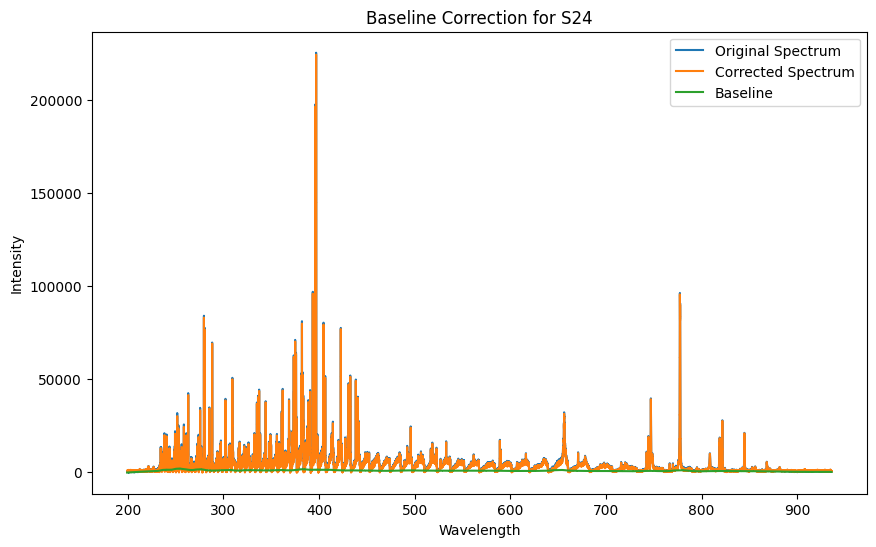

In [29]:

import sqlite3
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from astropy.modeling import models, fitting
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output, State
from dash import dash_table
from flask import Flask
import plotly.colors as pc
import numpy as np
import sqlite3
import pandas as pd
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        data = conn.execute(query, (element, sp_num)).fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name, iteration):
        conn = sqlite3.connect(self.db_spectrum)
        query = """
            SELECT wavelength, intensity
            FROM spectrum_data
            WHERE sample_name = ? AND iteration = ?
            ORDER BY wavelength
        """
        data = conn.execute(query, (sample_name, iteration)).fetchall()
        conn.close()
        if not data:
            return np.array([]), np.array([])
        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)
    def get_peak_data(sample_name):
        excel_file = f"da/{sample_name}.xlsx"

        try:
          df = pd.read_excel(excel_file)
          return df
        except FileNotFoundError:
          print(f"Excel file not found: {excel_file}")
          return pd.DataFrame()
        except Exception as e:
          print(f"Error reading Excel file: {e}")
          return pd.DataFrame()



def baseline_als(intensities, lam, p, niter):
    lam = lam *1e4
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z
db_spectrum = 'tanah_vulkanik.db'  # Ganti dengan nama database spektrummu
sample_name = 'S24'
iteration = 1  # Ganti dengan iterasi data yang ingin diolah
lam = 1e4  # Parameter tuning untuk baseline_als
p = 0.001  # Parameter tuning untuk baseline_als
niter = 7  # Parameter tuning untuk baseline_als

# Mengambil data eksperimental
fetcher = DataFetcher(None, db_spectrum)  # Inisialisasi DataFetcher
wavelengths, intensities = fetcher.get_experimental_data(sample_name, iteration)

# Koreksi baseline
baseline = baseline_als(intensities, lam, p, niter)
corrected_intensities = intensities - baseline

# Menyimpan data
df = pd.DataFrame({
    'Wavelength': wavelengths,
    'Original Intensity': intensities,
    'Corrected Intensity': corrected_intensities
})
df.to_excel(f'hasil_koreksi_baseline_{sample_name}.xlsx', index=False)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, intensities, label='Original Spectrum')
plt.plot(wavelengths, corrected_intensities, label='Corrected Spectrum')
plt.plot(wavelengths, baseline, label='Baseline')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title(f'Baseline Correction for {sample_name}')
plt.legend()
plt.show()